# Cell Segmentation with Cellpose
---

This notebook demonstrates how to use `arcadia-microscopy-tools` to segment cells in microscopy images using the built-in Cellpose integration.

This page is rendered from a jupyter notebook (`docs/examples/cell_segmentation.ipynb`). When the docs are built, the notebook will be executed and then rendered.

### Imports

First, let's import the necessary libraries:

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from arcadia_microscopy_tools import ImageOperation, MicroscopyImage, Pipeline
from arcadia_microscopy_tools.model import SegmentationModel
from arcadia_microscopy_tools.operations import rescale_by_percentile
from cellpose.utils import outlines_list



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.12.8 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




### Loading the Image

We'll load a sample PBMC (Peripheral Blood Mononuclear Cell) image that contains multiple fluorescence channels. For cell segmentation, we'll use the brightfield channel.

In [2]:
# Locate the sample ND2 file in the test data directory
sample_data_directory = Path("../../src/arcadia_microscopy_tools/tests/data")
nd2_path = next(sample_data_directory.glob("example-pbmc.nd2"))
print("ND2 file:", nd2_path)

# Load the microscopy image
image = MicroscopyImage.from_nd2_path(nd2_path)
image  # Display the image object representation

ND2 file: ../../src/arcadia_microscopy_tools/tests/data/example-pbmc.nd2


MicroscopyImage(sizes={'C': 4, 'Y': 256, 'X': 256}, channels=['BRIGHTFIELD', 'DAPI', 'FITC', 'TRITC'], intensities=[2049, 1977, 1894, ..., 778, 810, 808], dtype=uint16)

### Preprocessing the Image

Before segmentation, we'll preprocess the brightfield channel to improve contrast. We use a pipeline that rescales pixel intensities based on percentiles, which helps normalize the image and enhance cell boundaries.

The `rescale_by_percentile` operation clips extreme values and rescales the image to use the full intensity range, making cells easier to detect.

In [3]:
# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline(
    [ImageOperation(rescale_by_percentile, percentile_range=(0.1, 99.9))]
)

# Select the brightfield channel for segmentation
channel = image.channels[0]  # BRIGHTFIELD

# Apply preprocessing
preprocessed = image.apply_pipeline(preprocessing_pipeline, channel=channel)

### Running Cell Segmentation

The `SegmentationModel` class provides a simple interface to Cellpose, a deep learning-based cell segmentation tool. The model automatically detects cell boundaries and assigns each pixel to a cell (or background).

The resulting mask is a 2D array where each cell has a unique integer ID, and background pixels are labeled as 0.

In [4]:
# Initialize the segmentation model
model = SegmentationModel()

# Run segmentation on the preprocessed image
mask = model.segment(preprocessed.astype(float))

### Visualizing Segmentation Results

Finally, let's visualize the segmentation by overlaying cell outlines on the original image. We use Cellpose's `outlines_list` utility to extract the contours of each segmented cell, then plot them on top of the brightfield image.

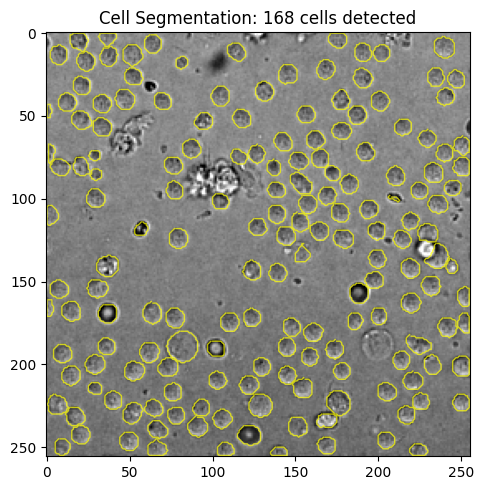

In [5]:
# Get cell outlines as list of (x, y) coordinates
cell_outlines = outlines_list(mask)

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

# Display the preprocessed image in grayscale
ax.imshow(preprocessed, cmap="gray")

# Overlay cell outlines in yellow
for coords_xy in cell_outlines:
    ax.plot(coords_xy[:, 0], coords_xy[:, 1], color="#ffff00", lw=1, alpha=0.7)

_ = ax.set_title(f"Cell Segmentation: {len(cell_outlines)} cells detected")
plt.tight_layout()